# Create Trimesh Grid for McDonald Valley Problem

## Load Modules and Setup Notebook

In [17]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

from flopy.utils.gridgen import Gridgen 

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.16.2
matplotlib version: 3.0.3
flopy version: 3.2.12


## Create Base Grid

In [18]:
nlay = 5
nrow = 40
ncol = 25
delr = 500.
delc = 500.
top = 100.
botm = np.zeros((nlay, nrow, ncol), dtype=np.float32)
botm[0] = -5.
botm[1] = -50
botm[2] = -51
botm[3] = -100
fname = './data/bottom.csv'
botm[4] = np.loadtxt(fname, delimiter=',')
ms = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(ms, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr,
                               delc=delc, top=top, botm=botm)

## Read the Trimesh File into Python

In [19]:
fname = './data/TriMesh_with_densified_contours.exp'
with open(fname, 'r') as f:
    lines = f.readlines()

# read vertex info into a structured array
vtmp = [line.strip().split()[1:] for line in lines if line.startswith('N')]
dtype = [('ivert', int), ('x', float), ('y', float), ('label', '|S10'), ('ibound', int), ('elev', float)]
vertices = np.empty((len(vtmp)), dtype=dtype)
for i, line in enumerate(vtmp):
    for j, val in enumerate(line):
        vertices[i][j] = val

# read element info into a structured array
etmp = [line.strip().split()[1:] for line in lines if line.startswith('E')]
dtype = [('icell', int), ('iv1', int), ('iv2', int), ('iv3', int), ('label', '|S10'), ('ibound', int), ('elev', float)]
cells = np.empty((len(etmp)), dtype=dtype)
for i, line in enumerate(etmp):
    for j, val in enumerate(line):
        cells[i][j] = val

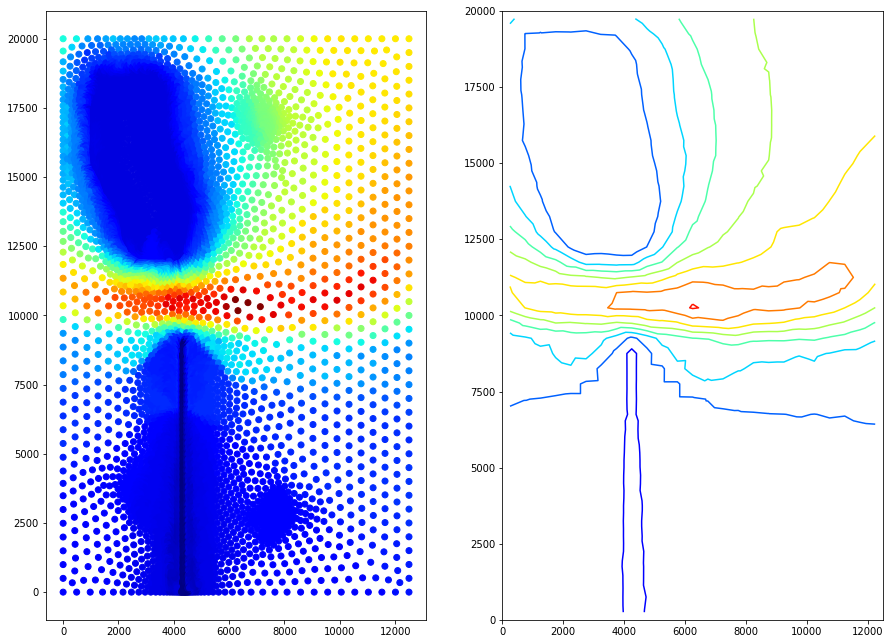

In [20]:
from scipy.interpolate import griddata
xc, yc, zc = ms.modelgrid.xyzcellcenters
top = griddata((vertices['x'], vertices['y']), vertices['elev'], (xc, yc))
np.savetxt('mv-top.dat', top, fmt='%6.2f')

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1, aspect='equal')
ax.scatter(vertices['x'], vertices['y'], c=vertices['elev'], cmap='jet')

ax = fig.add_subplot(1, 2, 2, aspect='equal')
pmv = flopy.plot.PlotMapView(ax=ax, model=ms)
pmv.contour_array(a=top, cmap='jet')
#ax.imshow(top, cmap='jet')

In [21]:
verts = []
for ivert, x, y, label, ibound, elev in vertices:
    verts.append([x, y])
verts = np.array(verts, dtype=np.float)
    
iverts = []
for i, iv1, iv2, iv3, s, ibound, elev in list(cells):
    iverts.append([iv3 - 1, iv2 - 1, iv1 - 1])
    
ncpl = len(iverts)
nvert = verts.shape[0]

(0.0, 20000.0)

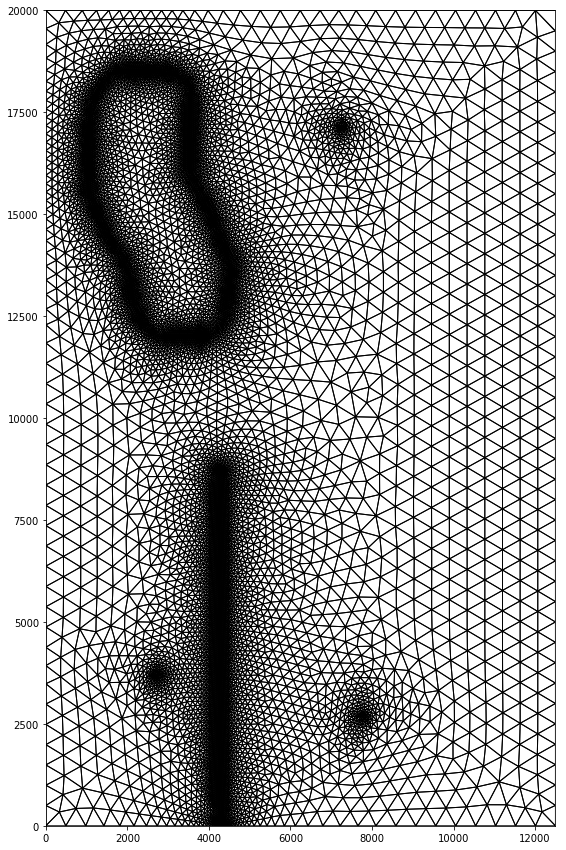

In [22]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=ms)
mm.plot_cvfd(verts, iverts, facecolor='none', edgecolor='k')
plt.xlim(verts[:, 0].min(), verts[:, 0].max())
plt.ylim(verts[:, 1].min(), verts[:, 1].max())

(0.0, 20000.0)

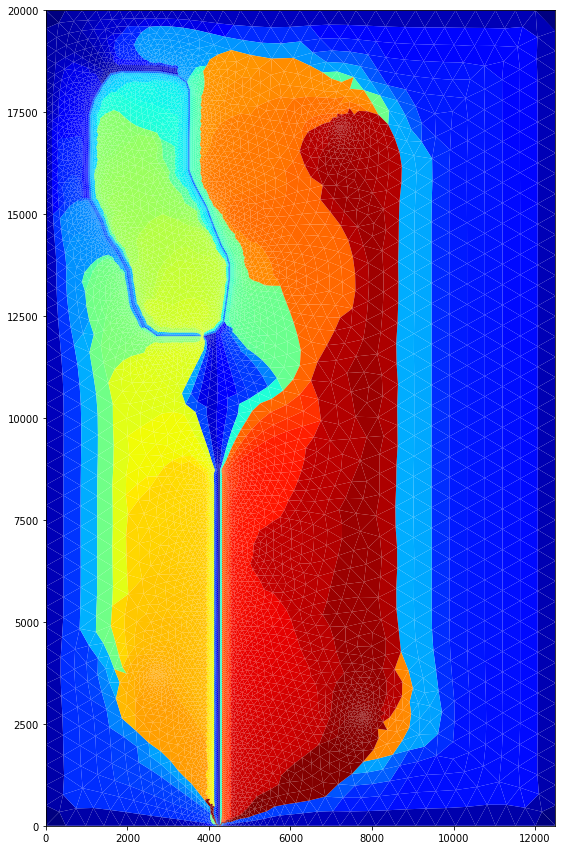

In [23]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=ms)
mm.plot_cvfd(verts, iverts, a=np.arange(len(iverts)), edgecolor='none', cmap='jet')
plt.xlim(verts[:, 0].min(), verts[:, 0].max())
plt.ylim(verts[:, 1].min(), verts[:, 1].max())

## Calculate Centroids

(0.0, 20000.0)

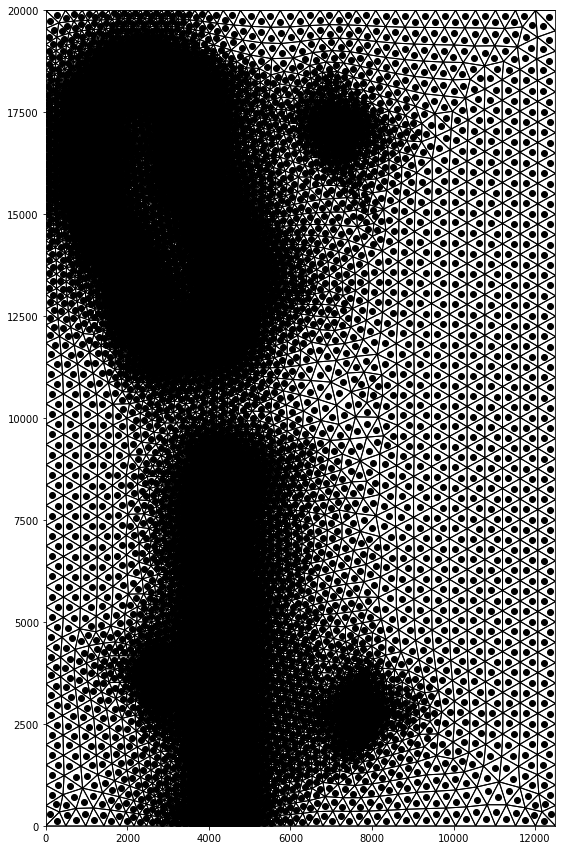

In [24]:
# centroid and area array
from flopy.utils.cvfdutil import centroid_of_polygon, area_of_polygon
xcyc = np.empty((ncpl, 2), dtype=np.float)
area = np.empty((ncpl), dtype=np.float)
for icell in range(ncpl):
    vlist = [(verts[ivert, 0], verts[ivert, 1]) for ivert in iverts[icell]]
    xcyc[icell, 0], xcyc[icell, 1] = centroid_of_polygon(vlist)
    area[icell] = abs(area_of_polygon(*zip(*vlist)))
    
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=ms)
mm.plot_cvfd(verts, iverts, facecolor='none', edgecolor='k')
plt.plot(xcyc[:, 0], xcyc[:, 1], 'ko')
plt.xlim(verts[:, 0].min(), verts[:, 0].max())
plt.ylim(verts[:, 1].min(), verts[:, 1].max())

## Create DISV Arrays

In [25]:
bot = np.loadtxt('./data/bottom.csv', delimiter=',')
bot_tm = ms.sr.interpolate(bot, xcyc)

vertices = []
for i in range(nvert):
    vertices.append((i, verts[i, 0], verts[i, 1]))

cell2d = []
for i in range(ncpl):
    cell2d.append([i, xcyc[i, 0], xcyc[i, 1], 3] + [iv for iv in iverts[i]])    

   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None


## Intersect the Grid with the Property Arrays

(0.0, 20000.0)

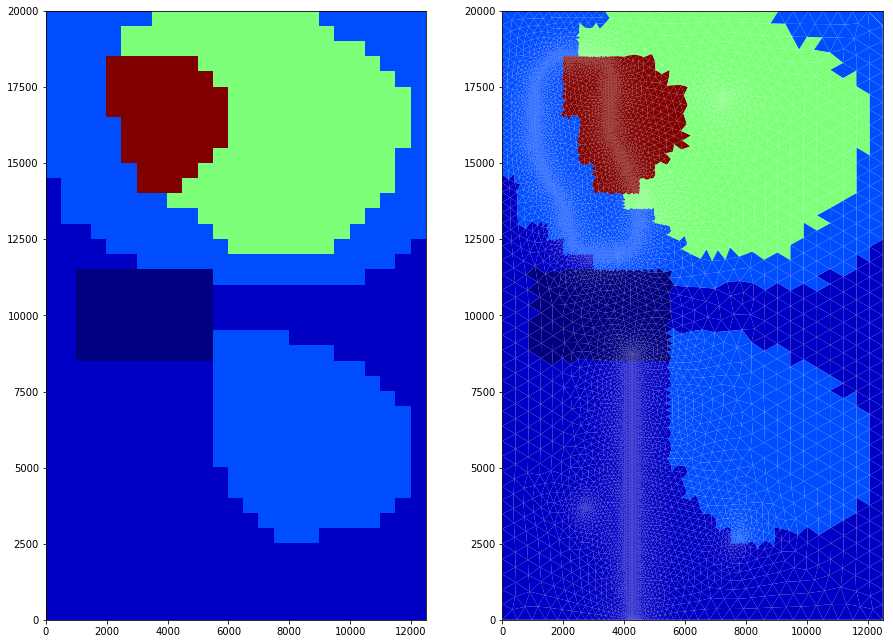

In [26]:
kaq = np.loadtxt('./data/k_aq.csv', delimiter=',')
kaq_tm = ms.sr.interpolate(kaq, xcyc)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=ms, ax=ax)
mm.plot_array(kaq, cmap='jet')

ax = fig.add_subplot(1, 2, 2, aspect='equal')
mm = flopy.plot.PlotMapView(model=ms, ax=ax)
mm.plot_cvfd(verts, iverts, a=kaq_tm, edgecolor='none', cmap='jet')
plt.xlim(verts[:, 0].min(), verts[:, 0].max())
plt.ylim(verts[:, 1].min(), verts[:, 1].max())

(0.0, 20000.0)

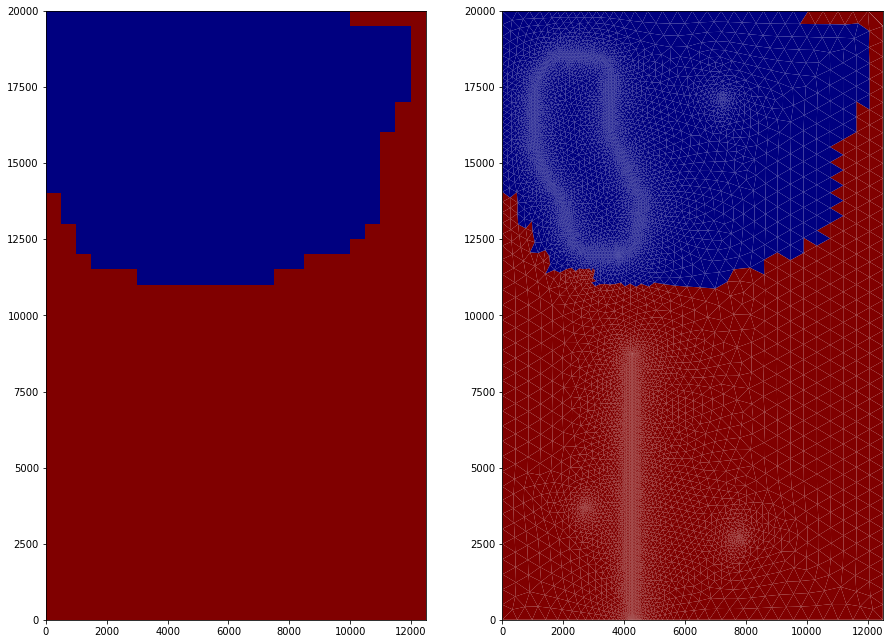

In [27]:
from flopy.utils.gridgen import read1d
kclay = np.empty((dis.nrow * dis.ncol), dtype=np.float)
f = open('./data/k_clay.txt', 'r')
kclay = read1d(f, kclay).reshape((dis.nrow, dis.ncol))
kclay_tm = ms.sr.interpolate(kclay, xcyc)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=ms, ax=ax)
mm.plot_array(kclay, cmap='jet')


ax = fig.add_subplot(1, 2, 2, aspect='equal')
mm = flopy.plot.PlotMapView(model=ms, ax=ax)
mm.plot_cvfd(verts, iverts, a=kclay_tm, edgecolor='none', cmap='jet')
plt.xlim(verts[:, 0].min(), verts[:, 0].max())
plt.ylim(verts[:, 1].min(), verts[:, 1].max())

## Intersect the Features with the Grid

(0.0, 20000.0)

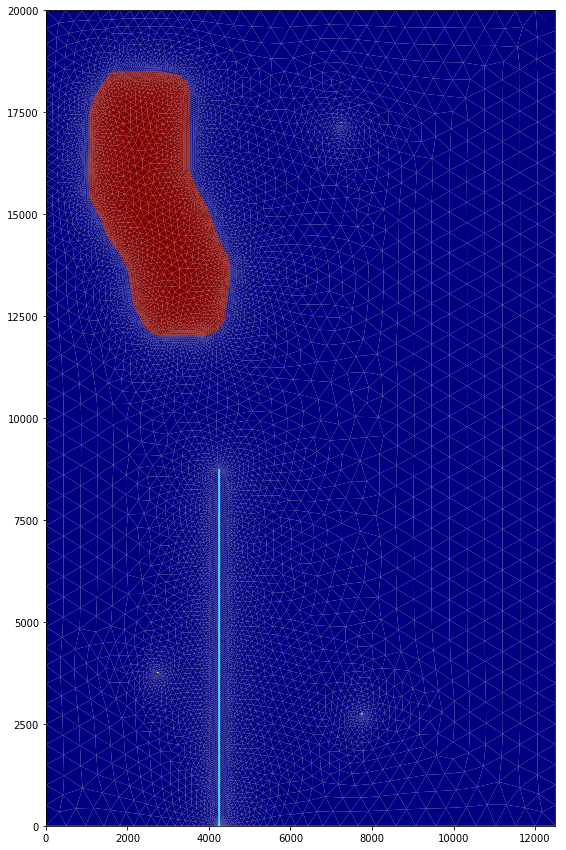

In [28]:
ibd = cells['ibound']
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=ms)
mm.plot_cvfd(verts, iverts, a=ibd, edgecolor='none', cmap='jet')
plt.xlim(verts[:, 0].min(), verts[:, 0].max())
plt.ylim(verts[:, 1].min(), verts[:, 1].max())

In [29]:
iriv = 1
iwel = 2
ilak = 3

idx = cells['ibound'] == iriv

rbot = -2.
ct = 0.
at = 0.

# cond_scale is needed to make sure the total conductance
# is similar to what is in the regular grid.
cond_scale = 10.28
rivspd = []
for ip1, iv1, iv2, iv3, txt, ibound, elev in cells[idx]:
    icell = ip1 - 1
    distance = xcyc[icell, 1]
    stage = 0. + distance / (18 * delc)
    cond = 1.e5
    cond = cond / (delc * delr) * area[icell]
    cond = cond * cond_scale
    ct += cond
    at += area[icell]
    rivspd.append([(0, icell), stage, cond, rbot])

In [30]:
iriv = 1
iwel = 2
ilak = 3
idx = cells['ibound'] == ilak
chdspd = [[(0, ip1 - 1), 11.] for ip1, iv1, iv2, iv3, txt, ibound, elev in cells[idx]]

## Build the Model

In [31]:
ws = './model'
name = 'mv'
sim = flopy.mf6.MFSimulation(sim_ws=ws, sim_name=name, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, complexity='complex')
gwf = flopy.mf6.ModflowGwf(sim, save_flows=True)
dis = flopy.mf6.ModflowGwfdisv(gwf, nlay=5, ncpl=ncpl, nvert=nvert, 
                               top=cells['elev'],
                               botm=[-5, -50, -51, -100., bot_tm],
                               vertices=vertices, cell2d=cell2d)
ic = flopy.mf6.ModflowGwfic(gwf, strt=11.)
npf = flopy.mf6.ModflowGwfnpf(gwf, 
                              xt3doptions=True, save_specific_discharge=True,
                              icelltype=[1, 0, 0, 0, 0],
                              k=[kaq_tm, kaq_tm, kclay_tm, kaq_tm, kaq_tm],
                              k33=[0.25 * kaq_tm, 0.25 * kaq_tm, kclay_tm, 0.25 * kaq_tm, 0.25 * kaq_tm])
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=.003641)
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd)
oc = flopy.mf6.ModflowGwfoc(gwf, 
                            head_filerecord=name + '.hds', 
                            budget_filerecord=name + '.bud',
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model model...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 4590 based on size of stress_period_data
    writing package rcha...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 728 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: /Users/langevin/langevin/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

  MODFLOW 6 compiled Mar 14 2019 09:20:00 with GFORTRAN compiler (ver. 8.2.0)

This software has been approved for release by the U.S. Geological 
Survey 

(True, [])

## Post-Process the Results

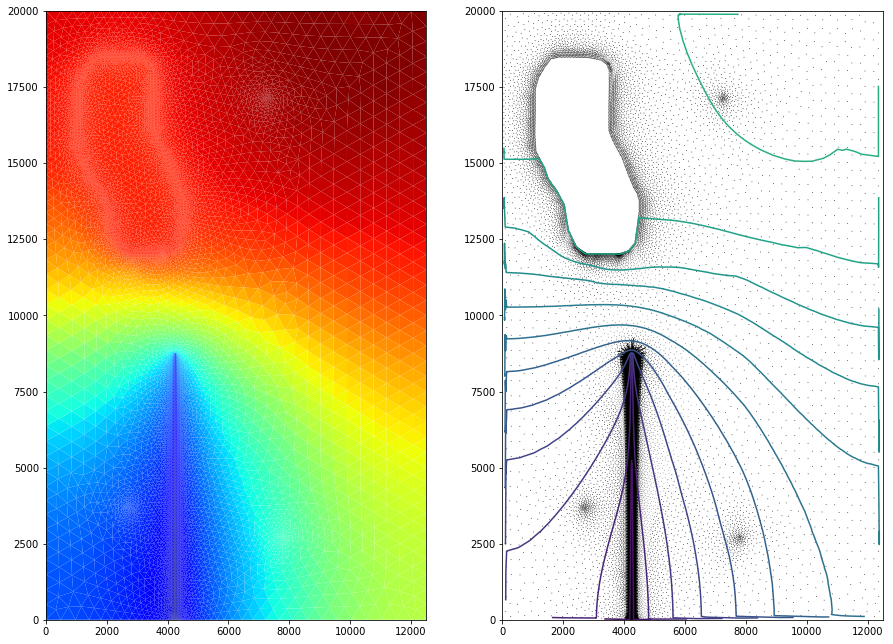

In [32]:
from flopy.utils.binaryfile import HeadFile, CellBudgetFile
fname = os.path.join(ws, name + '.hds')
headobj = HeadFile(fname)
head = headobj.get_data()[:, 0, :]
fname = os.path.join(ws, name + '.bud')
budobj = CellBudgetFile(fname, precision='double')
spdis = budobj.get_data(text='DATA-SPDIS')

ilay = 0

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
pmv.plot_array(head, cmap='jet')
#pmv.plot_grid()

ax = fig.add_subplot(1, 2, 2, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
pmv.contour_array(head, levels=np.arange(20))
pmv.plot_specific_discharge(spdis)